<a href="https://colab.research.google.com/github/omid-sar/Interview-Preparation/blob/main/ML_interview/LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# ---------------------------------------------- Downlaod ----------------------------------------------
import requests

url = "https://raw.githubusercontent.com/omid-sar/Project_Data_Hub/main/twitter_toxic_final_balanced_dataset.csv"
response = requests.get(url)

if response.status_code == 200:
    with open("twitter_toxic.csv", "wb") as file:
        file.write(response.content)
    print("File downloaded and saved successfully")
else:
    print(f"Failed download successfully. Status code: {response.status_code}")

# ----------------------------------------------- Read --------------------------------------------------
import pandas as pd
import numpy as np

df = pd.read_csv("twitter_toxic.csv")
df = df.drop(columns=["Unnamed: 0"])
df.head(2)


File downloaded and saved successfully


,Toxicity,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...


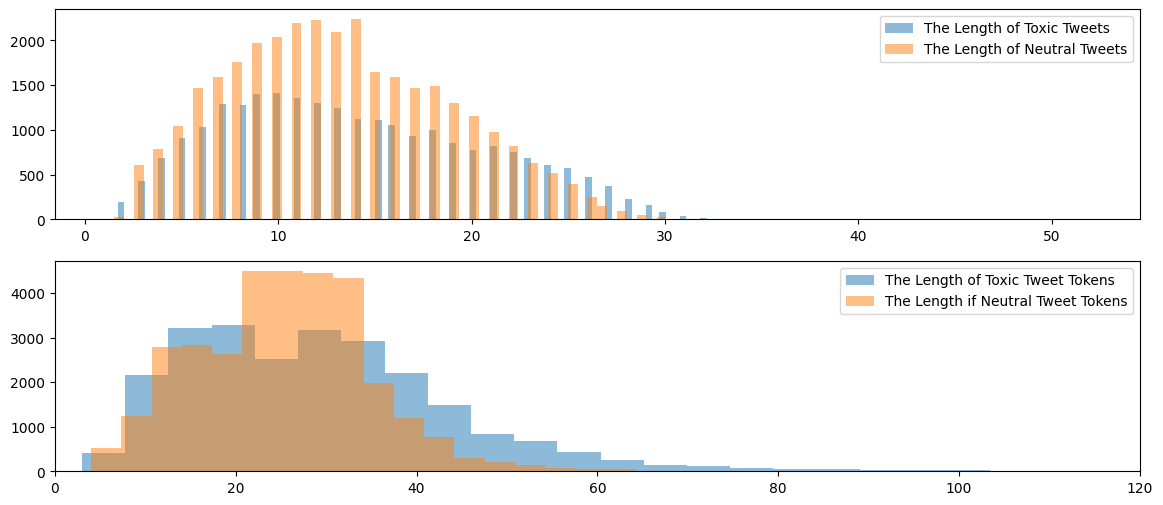

In [15]:
# ----------------------------------------------- EDA -----------------------------------------------------
import matplotlib.pyplot as plt
from  transformers import BertTokenizer

df["tweet_length"] = [len(seq.split()) for seq in df["tweet"]]
toxic_len = df[df["Toxicity"] == 1]["tweet_length"]
neutral_len = df[df["Toxicity"] == 0]["tweet_length"]

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
df["token_lenght"] = [len(tokenizer(seq).input_ids) for seq in df["tweet"]]
toxic_token_len = df[df["Toxicity"] == 1]["token_lenght"]
neutral_token_len = df[df["Toxicity"] == 0]["token_lenght"]

fig, axes = plt.subplots(2,1 , figsize=(14,6))
axes[0].hist(toxic_len, bins=100, alpha=0.5, label='The Length of Toxic Tweets')
axes[0].hist(neutral_len, bins=100, alpha=0.5, label='The Length of Neutral Tweets')
axes[0].legend()

axes[1].hist(toxic_token_len, bins=100, alpha=0.5, label='The Length of Toxic Tweet Tokens')
axes[1].hist(neutral_token_len, bins=100, alpha=0.5, label='The Length if Neutral Tweet Tokens')
axes[1].set_xlim([0, 120])
axes[1].legend()
plt.show()


In [16]:
# ----------------------------------------------- Dataset -----------------------------------------------
import torch
from torch.utils.data import  Dataset, TensorDataset

class MyDataset(Dataset):

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

X = [seq for seq in df["tweet"]]
y= torch.tensor(df["Toxicity"].values, dtype=torch.long)

MAX_LENGTH=64
model_input = tokenizer(X, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
dataset = MyDataset(data=model_input.input_ids, labels=y)

# ----------------------------------------------- Data Loader ------------------------------------------------
from torch.utils.data import random_split, DataLoader

train_size = int(len(dataset) * 0.7)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset=dataset, lengths=[train_size, val_size, test_size])

batch_size = 32
num_workers = 2
dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2 , pin_memory=True)
dataloader_val = DataLoader(dataset=val_dataset, batch_size=batch_size)
dataloader_test = DataLoader(dataset=test_dataset, batch_size=batch_size)
next(iter(dataloader))


[tensor([[  101,  2026,  2035,  ...,     0,     0,     0],
         [  101,  2053, 15508,  ...,     0,     0,     0],
         [  101, 23596, 19387,  ...,     0,     0,     0],
         ...,
         [  101,  2339,  1029,  ...,     0,     0,     0],
         [  101,  1030,  5310,  ...,     0,     0,     0],
         [  101,  2057,  2253,  ...,     0,     0,     0]]),
 tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 1, 1, 0, 0, 0, 0, 0])]

In [17]:
# ----------------------------------------------- Model ------------------------------------------------
import torch.nn as nn

class MyLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, bidirectional=True, lstm_hidden_size=128,
                num_lstm_layers=2, hidden_layers=[256,128], num_classes=2):
        super(MyLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.num_lstm_layers = num_lstm_layers
        self.lstm_hidden_size = lstm_hidden_size
        self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=lstm_hidden_size, num_layers =num_lstm_layers,
                            batch_first=True, bidirectional=bidirectional)
        fc_input_size = 2 * lstm_hidden_size if bidirectional else lstm_hidden_size
        self.fc1 = nn.Linear(in_features=fc_input_size, out_features=hidden_layers[0])
        self.fc2 = nn.Linear(hidden_layers[0], hidden_layers[1])
        self.fc3 = nn.Linear(hidden_layers[1], num_classes)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embeddings(x)

        h0 = torch.zeros((2 if self.bidirectional else 1) * self.num_lstm_layers, x.size(0), self.lstm_hidden_size).to(device)
        c0 = torch.zeros((2 if self.bidirectional else 1) * self.num_lstm_layers, x.size(0), self.lstm_hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]

        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out))

        return out

VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 64
LSTM_HIDDEN_SIZE = 128
LSTM_NUM_LAYERs = 2
LSTM_BIDIRECTIONAL = True
HIDDEN_LAYERS = [256, 128]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyLSTM(vocab_size=VOCAB_SIZE)
model.to(device)
print(model)


MyLSTM(
  (embeddings): Embedding(30522, 64)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [38]:
# ---------------------------------------------- Training Loop ----------------------------------------------
import torch.optim as optim

LR_RATE = 0.001
optimizer = optim.Adam(params=model.parameters(), lr=LR_RATE)
criterion = nn.CrossEntropyLoss()

NUM_EPOCHS = 10
def training_loop(model, dataloader,dataloader_val,  optimizer, criterion, device, num_epochs=NUM_EPOCHS):
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        total_samples = 0

        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            if batch_idx % 100 == 0:
                print(f" Epoch: [{epoch+1}/ {num_epochs}], Step: [{batch_idx}/{len(dataloader)}], Batch Loss: [{loss.item():.4f}]")

        average_train_loss = total_train_loss / total_samples
        average_val_loss, val_accuracy = evaluation(model, dataloader_val, device, criterion)
        train_losses.append(average_val_loss)
        val_losses.append(average_val_loss)
        val_accuracies.append(val_accuracy)

        live_plot(train_losses, val_losses, val_accuracies, title=f'Epoch: {epoch+1}/{num_epochs}')

        print(f" { 100 * '='} \nAverage Training Loss: [{average_train_loss:.4f}] ")
        print(f"Average Validation Loss: {average_val_loss:.4f}, Accuracy: {val_accuracy:.2f} \n { 100 * '='}")



# ----------------------------------------------- Model Evaluation ------------------------------------------------
def evaluation(model, dataloader, device, criterion):
    model.eval()
    total_loss = 0
    correct_prediction = 0
    total_sample = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            _ , predicted = torch.max(outputs, 1)
            correct_prediction += (predicted == targets).sum().item()
            total_sample += targets.size(0)

    average_loss = total_loss/ total_sample
    accuracy = 100 * correct_prediction/ total_sample


    return average_loss, accuracy




In [37]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def live_plot(losses_train, losses_val, val_accuracies, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.plot(losses_train, label='Training Loss', color='red')
    ax1.legend(loc='lower left')
    ax1.set_ylabel('Training Loss')
    ax1.set_xlabel('Epoch')

    ax2 = ax1.twinx()
    ax2.plot(losses_val, label='Validation Loss', color='blue')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='green')
    ax2.legend(loc='lower right')
    ax2.set_ylabel('Validation Metrics')

    plt.title(title)
    plt.show()

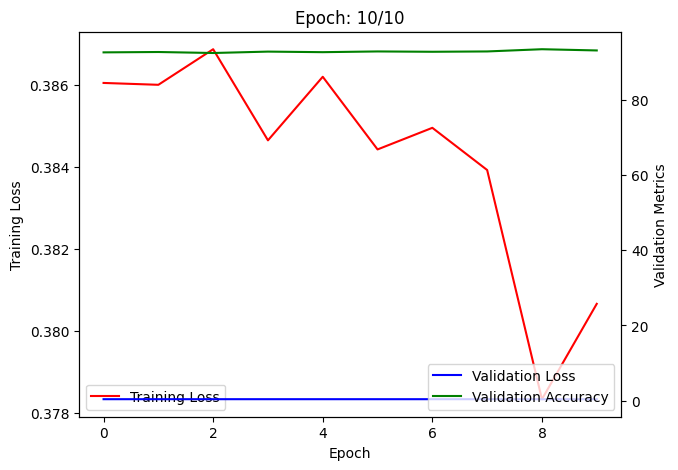

Average Training Loss: [0.3641] 
Average Validation Loss: 0.3807, Accuracy: 93.11 


In [39]:
# ----------------------------------------------- Main ------------------------------------------------

def main():
    training_loop(model=model,dataloader_val=dataloader_val, dataloader=dataloader,optimizer=optimizer, criterion=criterion, device=device, num_epochs=NUM_EPOCHS)


if __name__ == "__main__":
    main()

